In [46]:
# Exploratory Data Analysis
# Import necessary libraries for data exploration
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [48]:
# For dislaying plots inside notebook
%matplotlib inline

In [50]:
# For pretteir seaborn plots
sns.set(style='whitegrid')

In [52]:
# Load data from CSV files
sales_data = pd.read_csv('../data/raw/sales_data.csv')
inventory_data = pd.read_csv('../data/raw/inventory_data.csv')
workforce_data = pd.read_csv('../data/raw/workforce_data.csv')
events_data = pd.read_csv('../data/raw/external_events.csv')

In [54]:
# Checking the shape the of the data
print('Sales Data:', sales_data.shape)
print('Inventory Data:', inventory_data.shape)
print('Workforce Data:', workforce_data.shape)
print('External Events Data:', events_data.shape)

Sales Data: (109600, 9)
Inventory Data: (109600, 9)
Workforce Data: (27400, 8)
External Events Data: (157, 5)


In [56]:
# Data Preprocessing
# Convert 'Date' to datetime for all datasets
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
inventory_data['Date'] = pd.to_datetime(inventory_data['Date'])
workforce_data['Date'] = pd.to_datetime(workforce_data['Date'])
events_data['Date'] = pd.to_datetime(events_data['Event_Date'])

### 1. Develop Sales Forecasting Models

In [59]:
# Group by date to get total sales
daily_sales = sales_data.groupby('Date')['Sales_Amount'].sum()

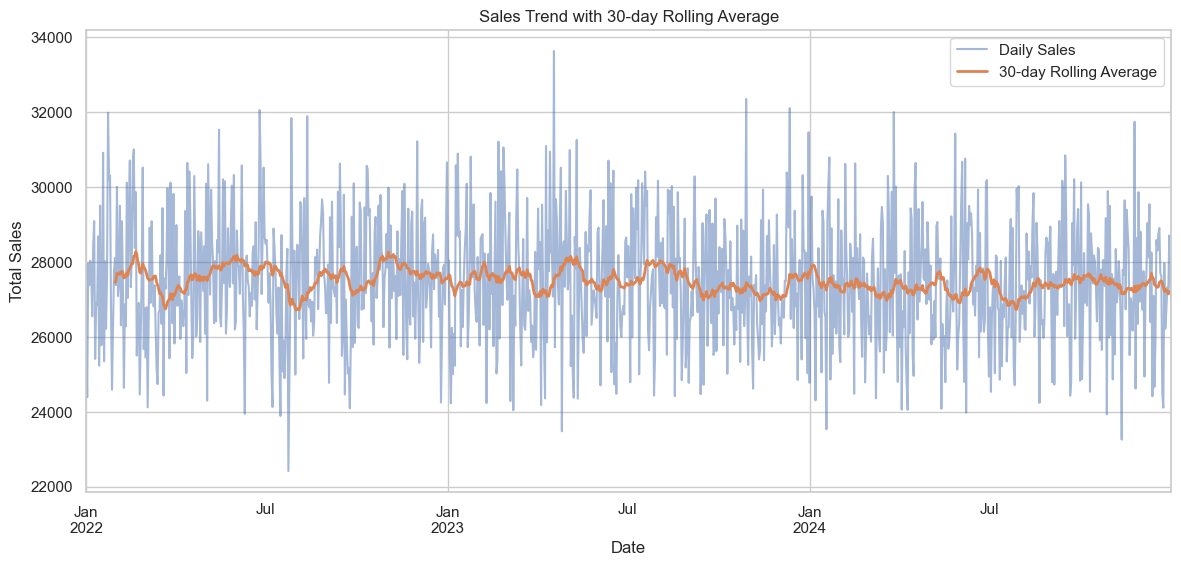

In [61]:
# Plot line chart of Sales Trend Over Time with a 30-day rolling average
daily_sales_rolling = daily_sales.rolling(window=30).mean()

plt.figure(figsize=(14, 6))
daily_sales.plot(alpha=0.5, label='Daily Sales')
daily_sales_rolling.plot(label='30-day Rolling Average', linewidth=2)
plt.title('Sales Trend with 30-day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

In [63]:
# -----------------------------------------
# Merge sales data and events data on date
# -----------------------------------------
combined_data = pd.merge(sales_data, events_data, on=['Date'], how='left')

In [65]:
# Add seasonality features
combined_data['Weekday'] = combined_data['Date'].dt.dayofweek  # Monday=0
combined_data['Month'] = combined_data['Date'].dt.month
combined_data['Quarter'] = combined_data['Date'].dt.quarter
combined_data['Year'] = combined_data['Date'].dt.year

In [67]:
# Drop descriptive columns we don’t need
combined_data = combined_data.drop(['Event_Date', 'Event_Description', 'City'], axis=1, errors='ignore')

In [69]:
# List of categorical columns to encode
categorical_cols = ['Store_ID', 'Product_ID', 'Product_Category', 
                    'Promotion_Flag', 'Event_Type', 'Weather_Condition', 'Impact_Level']

In [71]:
# Apply Label Encoding to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    combined_data[col] = le.fit_transform(combined_data[col])

In [73]:
# Sort data by date
combined_data.sort_values('Date', inplace=True)

In [75]:
# ----------------------------------------------------------
# Select features and target based on seasonality indicators
# ----------------------------------------------------------
features_a = ['Weekday', 'Month', 'Quarter', 'Year', 'Promotion_Flag'] + \
           [col for col in combined_data.columns if col.startswith('Event_Type')]

X1 = combined_data[features_a]
y1 = combined_data['Sales_Amount']

In [77]:
# Split data by date into train and test and use last 20% as test
# This is chronological rather than a random train-test split 
split_idx = int(len(combined_data) * 0.8)
X1_train, X1_test = X1.iloc[:split_idx], X1.iloc[split_idx:]
y1_train, y1_test = y1.iloc[:split_idx], y1.iloc[split_idx:]

In [79]:
# Train the model
xgb_model1 = XGBRegressor(n_estimators = 100, random_state = 42)
xgb_model1.fit(X1_train, y1_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [81]:
# Predict with test split
y1_pred = xgb_model1.predict(X1_test)

In [83]:
# Evaluate the performance of the model
rmse1 = root_mean_squared_error(y1_test, y1_pred)
mae1 = mean_absolute_error(y1_test, y1_pred)

print('Root Mean Squared Error (RMSE):', rmse1)
print('Mean Absolute Error (MAE):', mae1)

Root Mean Squared Error (RMSE): 161.65616733007312
Mean Absolute Error (MAE): 131.33685470149464


In [85]:
# ------------------------------------------
# Select all features except Date and target
# ------------------------------------------
features_b = [col for col in combined_data.columns if col not in ['Date', 'Sales_Amount']]
X2 = combined_data[features_b]
y2 = combined_data['Sales_Amount']

In [87]:
# Split data by date into train and test and use last 20% as test
# This is chronological rathen than a random train-test split 
split_idx = int(len(combined_data) * 0.8)

X2_train, X2_test = X2.iloc[:split_idx], X2.iloc[split_idx:]
y2_train, y2_test = y2.iloc[:split_idx], y2.iloc[split_idx:]

In [89]:
# Train the second model
xgb_model2 = XGBRegressor(n_estimators=100, random_state=42)
xgb_model2.fit(X2_train, y2_train)

y2_pred = xgb_model2.predict(X2_test)

In [91]:
# Predict optimal hours for full dataset
combined_data['Predicted_Sales'] = xgb_model2.predict(X2)

In [93]:
# Evaluate the performance of the second model
rmse2 = root_mean_squared_error(y2_test, y2_pred)
mae2 = mean_absolute_error(y2_test, y2_pred)

print('Root Mean Squared Error (RMSE):', rmse2)
print('Mean Absolute Error (MAE):', mae2)

Root Mean Squared Error (RMSE): 138.56258458692886
Mean Absolute Error (MAE): 113.51048209059672


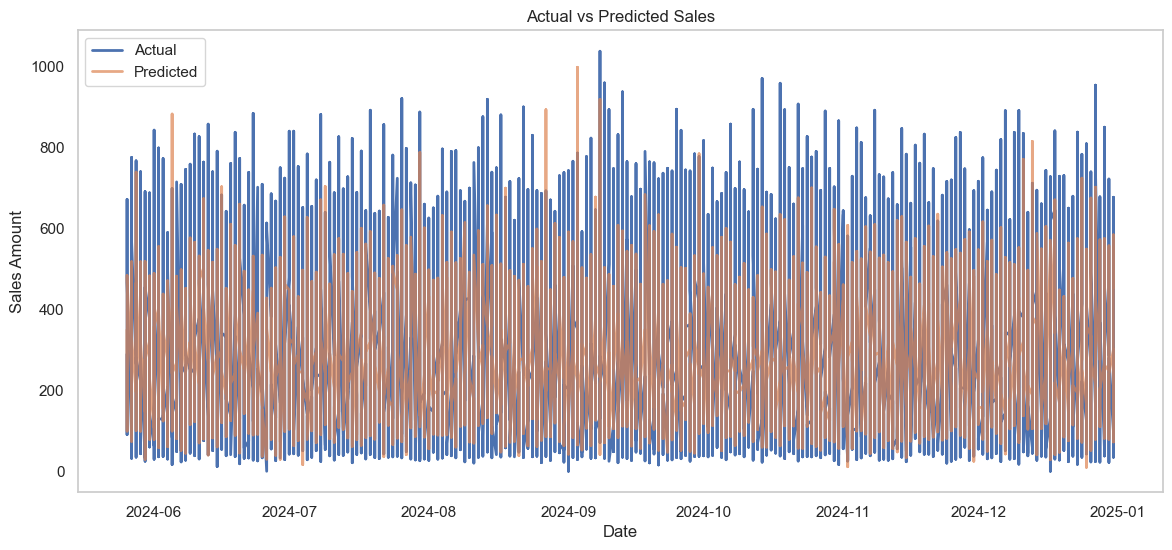

In [95]:
# Plot actual vs predicted sales
test_dates = combined_data['Date'].iloc[split_idx:]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y2_test.values, label='Actual', linewidth=2)
plt.plot(test_dates, y2_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(False)
plt.show()

In [97]:
print(combined_data.head())

         Date  Store_ID  Product_ID  Product_Category  Quantity_Sold  \
0  2022-01-01         3         323                 1             12   
72 2022-01-01         9         242                 1             11   
71 2022-01-01         9          18                 1              6   
70 2022-01-01         9         279                 0             10   
69 2022-01-01         9         176                 2              3   

    Sales_Amount  Promotion_Flag  Weather_Condition  Temperature_C  \
0         144.25               0                  0           22.3   
72        240.43               0                  1           29.4   
71        137.60               1                  0           29.2   
70        271.23               0                  1           27.1   
69        130.49               0                  0           30.6   

    Event_Type  Impact_Level  Weekday  Month  Quarter  Year  Predicted_Sales  
0            0             2        5      1        1  2022       3

### 2. Predict Optimal Inventory Levels

In [100]:
# Aggregate sales data to match inventory granularity
sales_agg = sales_data.groupby(['Date', 'Store_ID', 'Product_ID'])['Quantity_Sold'].sum().reset_index()

In [102]:
# Merge inventory + aggregated sales
merged_data = pd.merge(inventory_data, sales_agg, on=['Date', 'Store_ID', 'Product_ID'], how='left')

In [104]:
# Fill in missing values with 0
merged_data['Quantity_Sold'] = merged_data['Quantity_Sold'].fillna(0)

In [106]:
# Add seasonality features
merged_data['Weekday'] = merged_data['Date'].dt.dayofweek
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Quarter'] = merged_data['Date'].dt.quarter
merged_data['Year'] = merged_data['Date'].dt.year

In [108]:
# Sort and calculate 14-day rolling average
merged_data.sort_values(['Store_ID', 'Product_ID', 'Date'], inplace=True)
merged_data['Avg_Demand_14d'] = merged_data.groupby(['Store_ID', 'Product_ID'])['Quantity_Sold'] \
    .transform(lambda x: x.rolling(window=14, min_periods=1).mean())

merged_data['Demand_STD_14d'] = merged_data.groupby(['Store_ID', 'Product_ID'])['Quantity_Sold'] \
    .transform(lambda x: x.rolling(window=14, min_periods=1).std().fillna(0))

In [109]:
merged_data['Optimal_Inventory'] = (
    merged_data['Avg_Demand_14d'] * merged_data['Supplier_Lead_Time_Days'] +
    1.65 * merged_data['Demand_STD_14d']  # 95% confidence interval safety stock
)

In [110]:
# Preview results
print(merged_data[['Quantity_Sold', 'Avg_Demand_14d', 'Optimal_Inventory']].describe())

       Quantity_Sold  Avg_Demand_14d  Optimal_Inventory
count  109600.000000   109600.000000      109600.000000
mean        0.198294        0.198366           2.517688
std         1.466056        0.606385           7.276080
min         0.000000        0.000000           0.000000
25%         0.000000        0.000000           0.000000
50%         0.000000        0.000000           0.000000
75%         0.000000        0.000000           0.000000
max        21.000000       16.000000         210.000000


In [111]:
# Select a store-product combination with some nonzero sales
nonzero_sample = merged_data[(merged_data['Quantity_Sold'] > 0)]
sample_comb = nonzero_sample[['Store_ID', 'Product_ID']].iloc[0]

sample_data = merged_data[(merged_data['Store_ID'] == sample_comb['Store_ID']) &
                          (merged_data['Product_ID'] == sample_comb['Product_ID'])]

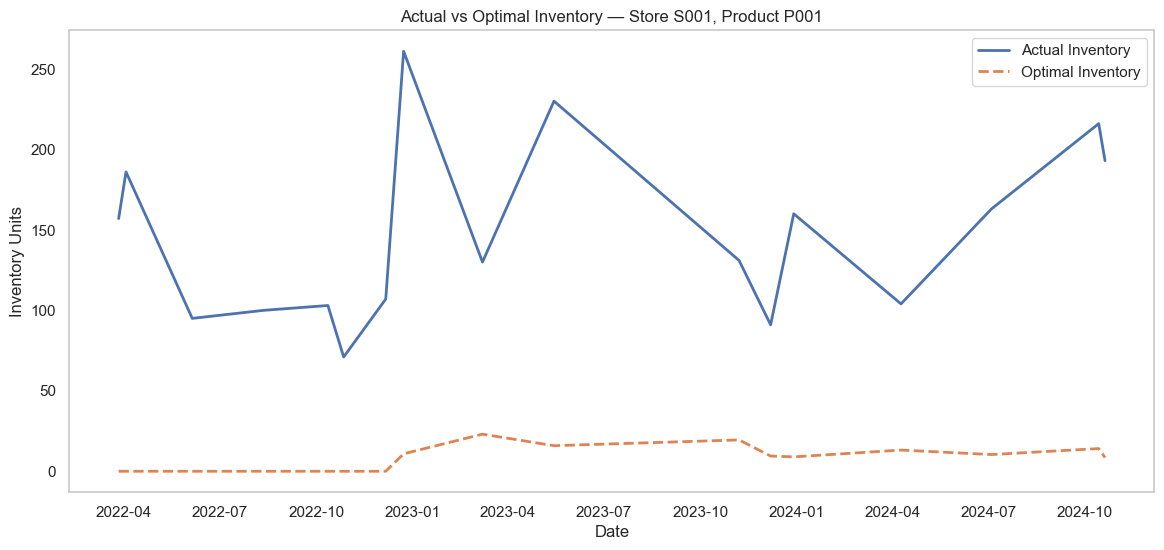

In [112]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(sample_data['Date'], sample_data['Closing_Inventory'], label='Actual Inventory', linewidth=2)
plt.plot(sample_data['Date'], sample_data['Optimal_Inventory'], label='Optimal Inventory', linestyle='--', linewidth=2)
plt.title(f"Actual vs Optimal Inventory — Store {sample_comb['Store_ID']}, Product {sample_comb['Product_ID']}")
plt.xlabel('Date')
plt.ylabel('Inventory Units')
plt.legend()
plt.grid(False)
plt.show()

In [113]:
# Calculate over and understock rates
merged_data['Overstock_Flag'] = merged_data['Closing_Inventory'] > merged_data['Optimal_Inventory']
merged_data['Understock_Flag'] = merged_data['Closing_Inventory'] < merged_data['Optimal_Inventory']

overstock_rate = merged_data['Overstock_Flag'].mean()
understock_rate = merged_data['Understock_Flag'].mean()

print('Overstock rate:', overstock_rate)
print('Understock rate:', understock_rate)

Overstock rate: 0.9987773722627737
Understock rate: 0.0009945255474452554


In [118]:
# Train XGBoost model to predict Optimal Inventory
# Select features
feature_cols3 = ['Weekday', 'Month', 'Quarter', 'Year', 
                'Supplier_Lead_Time_Days', 'Avg_Demand_14d', 'Demand_STD_14d']

In [121]:
# Define X and y
X3 = merged_data[feature_cols3]
y3 = merged_data['Optimal_Inventory']

In [124]:
# Train/test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [126]:
# Train XGBoost model
xgb_model3 = XGBRegressor(n_estimators=100, random_state=42)
xgb_model3.fit(X3_train, y3_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [128]:
# Predict 
y3_pred = xgb_model3.predict(X3_test)

In [130]:
# Predict optimal hours for full dataset
merged_data['Predicted_Optimal_Inventory'] = xgb_model3.predict(X3)

In [132]:
print(merged_data.head())

            Date Store_ID Product_ID  Opening_Inventory  Inventory_Received  \
8509  2022-03-27     S001       P001                175                  12   
9250  2022-04-03     S001       P001                166                  62   
15553 2022-06-05     S001       P001                106                  37   
22322 2022-08-12     S001       P001                124                   2   
28426 2022-10-12     S001       P001                 86                  52   

       Closing_Inventory  Wastage_Units  Inventory_Cost  \
8509                 157              2           34.21   
9250                 186              3           35.51   
15553                 95              7           34.45   
22322                100              4           34.99   
28426                103              0           24.44   

       Supplier_Lead_Time_Days  Quantity_Sold  Weekday  Month  Quarter  Year  \
8509                        13            0.0        6      3        1  2022   
9250      

In [134]:
# Evaluate performance of model
rmse3 = root_mean_squared_error(y3_test, y3_pred)
mae3 = mean_absolute_error(y3_test, y3_pred)

print('Optimal Inventory RMSE:', rmse3)
print('Optimal Inventory MAE:', mae3)

Optimal Inventory RMSE: 0.18068532908509788
Optimal Inventory MAE: 0.023243848308074338


### 3. Workforce Optimization Model

In [137]:
# Aggregate total staff and total hours per store per day
wf_agg = workforce_data.groupby(['Date', 'Store_ID']).agg({
    'Staff_ID': 'count',
    'Hours_Worked': 'sum'
}).reset_index()

wf_agg.rename(columns={'Staff_ID': 'Staff_Scheduled', 'Hours_Worked': 'Total_Hours_Worked'}, inplace=True)

In [139]:
print(wf_agg.head())

        Date Store_ID  Staff_Scheduled  Total_Hours_Worked
0 2022-01-01     S001                5                  33
1 2022-01-01     S004                5                  34
2 2022-01-01     S005                5                  26
3 2022-01-01     S008                5                  29
4 2022-01-01     S010                5                  41


In [141]:
# Merge with sales and events
combined_wf = pd.merge(wf_agg, sales_data, on=['Date', 'Store_ID'], how='left')
combined_wf = pd.merge(combined_wf, events_data, on='Date', how='left')

combined_wf['Sales_Amount'] = combined_wf['Sales_Amount'].fillna(0)
combined_wf['Event_Type'] = combined_wf['Event_Type'].fillna('None')

In [143]:
# Add seasonality features
combined_wf['Date'] = pd.to_datetime(combined_wf['Date'])
combined_wf['Weekday'] = combined_wf['Date'].dt.dayofweek
combined_wf['Month'] = combined_wf['Date'].dt.month
combined_wf['Quarter'] = combined_wf['Date'].dt.quarter
combined_wf['Year'] = combined_wf['Date'].dt.year

# Encode event type
combined_wf = pd.get_dummies(combined_wf, columns=['Event_Type'], drop_first=True)

In [145]:
# ------------------------------------------------
# Build Workforce Optimization Model with XGBOOST
# ------------------------------------------------
# Define features and target
feature_cols4 = ['Sales_Amount', 'Weekday', 'Month', 'Quarter'] + \
               [col for col in combined_wf.columns if col.startswith('Event_Type')]

X4 = combined_wf[feature_cols4]
y4 = combined_wf['Total_Hours_Worked']

In [147]:
# Split into training and testing sets
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, test_size=0.2, random_state=42
)

In [149]:
# Train XGBoost model
xgb_model4 = XGBRegressor(n_estimators=100, random_state=42)
xgb_model4.fit(X4_train, y4_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [150]:
# Predict and evaluate
y4_pred = xgb_model4.predict(X4_test)

rmse4 = root_mean_squared_error(y4_test, y4_pred)
print('Total Hours Worked RMSE:', rmse4)

Total Hours Worked RMSE: 3.8553789352604104


In [153]:
# Predict optimal hours for full dataset
combined_wf['Predicted_Optimal_Hours'] = xgb_model4.predict(X4)

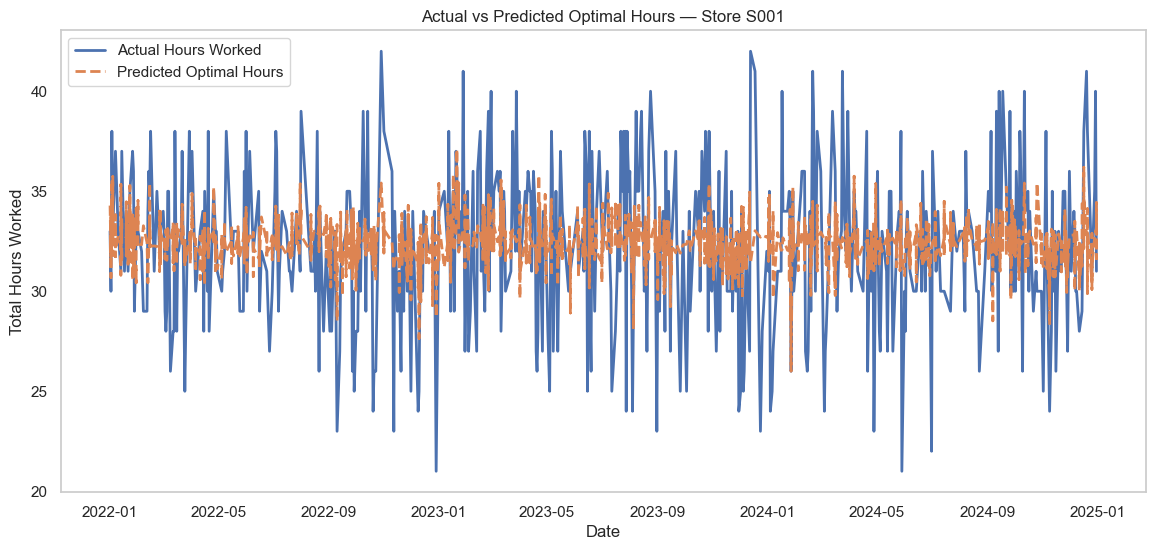

In [155]:
# Visualize actual vs predicted hours for one store
sample_store_id = combined_wf['Store_ID'].iloc[0]
sample_store = combined_wf[combined_wf['Store_ID'] == sample_store_id]

plt.figure(figsize=(14,6))
plt.plot(sample_store['Date'], sample_store['Total_Hours_Worked'], label='Actual Hours Worked', linewidth=2)
plt.plot(sample_store['Date'], sample_store['Predicted_Optimal_Hours'], label='Predicted Optimal Hours', linestyle='--', linewidth=2)
plt.title(f"Actual vs Predicted Optimal Hours — Store {sample_store_id}")
plt.xlabel('Date')
plt.ylabel('Total Hours Worked')
plt.legend()
plt.grid(False)
plt.show()

In [157]:
# Calculate overstaffing and understaffing rates
# Create flags
combined_wf['Overstaffed_Flag'] = combined_wf['Total_Hours_Worked'] > combined_wf['Predicted_Optimal_Hours']
combined_wf['Understaffed_Flag'] = combined_wf['Total_Hours_Worked'] < combined_wf['Predicted_Optimal_Hours']

In [159]:
# Calculate rates
overstaffing_rate = combined_wf['Overstaffed_Flag'].mean()
understaffing_rate = combined_wf['Understaffed_Flag'].mean()

In [161]:
# Print as percentages
print(f'Overstaffing rate: {overstaffing_rate:.2%}')
print(f'Understaffing rate: {understaffing_rate:.2%}')

Overstaffing rate: 49.76%
Understaffing rate: 50.24%


In [163]:
print(combined_data.head())
print(merged_data.head())
print(combined_wf.head())

         Date  Store_ID  Product_ID  Product_Category  Quantity_Sold  \
0  2022-01-01         3         323                 1             12   
72 2022-01-01         9         242                 1             11   
71 2022-01-01         9          18                 1              6   
70 2022-01-01         9         279                 0             10   
69 2022-01-01         9         176                 2              3   

    Sales_Amount  Promotion_Flag  Weather_Condition  Temperature_C  \
0         144.25               0                  0           22.3   
72        240.43               0                  1           29.4   
71        137.60               1                  0           29.2   
70        271.23               0                  1           27.1   
69        130.49               0                  0           30.6   

    Event_Type  Impact_Level  Weekday  Month  Quarter  Year  Predicted_Sales  
0            0             2        5      1        1  2022       3

#### Export data as CSV for Power BI analysis

In [188]:
# Preparing dataframes for export
# Rename combined_data → sales_events_data and apply fix
sales_events_data = combined_data.copy()
sales_events_data['Store_ID'] = sales_events_data['Store_ID'].replace(0, 10)
sales_events_data['Store_ID'] = 'S' + sales_events_data['Store_ID'].astype(int).astype(str).str.zfill(3)
sales_events_data['Product_ID'] = 'P' + sales_events_data['Product_ID'].astype(str).str.zfill(3)


In [190]:
# Promotion and Weather mapping dictionaries
promotion_map = {
    0: 'No',
    1: 'Yes'
}

weather_map = {
    0: 'Rainy',
    1: 'Stormy',
    2: 'Sunny'
}

In [192]:
sales_events_data['Promotion_Flag'] = sales_events_data['Promotion_Flag'].map(promotion_map)
sales_events_data['Weather_Condition'] = sales_events_data['Weather_Condition'].map(weather_map)

print(sales_events_data[['Promotion_Flag', 'Weather_Condition']].head())


   Promotion_Flag Weather_Condition
0              No             Rainy
72             No            Stormy
71            Yes             Rainy
70             No            Stormy
69             No             Rainy


In [194]:
# Rename merged_data → sales_inventory_data and apply fix
sales_inventory_data = merged_data.copy()
sales_inventory_data['Store_ID'] = sales_events_data['Store_ID'].replace(0, 10)
sales_inventory_data['Store_ID'] = sales_inventory_data['Store_ID'].str.replace('S', '', regex=False)
sales_inventory_data['Store_ID'] = 'S' + sales_inventory_data['Store_ID'].astype(str).str.zfill(3)

sales_inventory_data['Product_ID'] = sales_events_data['Product_ID'].replace(0, 10)
sales_inventory_data['Product_ID'] = sales_inventory_data['Product_ID'].str.replace('P', '', regex=False)
sales_inventory_data['Product_ID'] = 'P' + sales_inventory_data['Product_ID'].astype(str).str.zfill(3)


In [200]:
nonzero_count = (sales_inventory_data['Quantity_Sold'] > 0).sum()
zero_count = (sales_inventory_data['Quantity_Sold'] == 0).sum()
print(f"Nonzero Quantity_Sold rows: {nonzero_count}")
print(f"Zero Quantity_Sold rows: {zero_count}")


Nonzero Quantity_Sold rows: 2154
Zero Quantity_Sold rows: 107446


In [202]:
# Export sales events data
sales_events_data.to_csv('sales_events_data.csv', index=False)

# Export sales inventory data
sales_inventory_data.to_csv('sales_inventory_data.csv', index=False)

# Export sales workforce + events data
saleswf_events_data.to_csv('saleswf_events_data.csv', index=False)
